# PROTOTYPE 2

**NOTAS PESSOAIS**

**Kaggle:**

1. Precisa aceitar a competição com a mesma conta a usar na submissão.
2. Instalar a API do Kaggle facilita as coisas: `pip install kaggle`
3. Colocar chave de API em '~/.kaggle/kaggle.json' para poder usar a API do Kaggle.
4. Tem que ter entrado na competição pra poder usar a API do kaggle pra pegar as coisas.
5. `pipenv run kaggle competitions download -c lego-deffect-detection` baixa tudo da competição.

**Projeto:**

* Morfologia matemática parece ser a resposta.

**Pandas**

* Lembra de usar `df.at[line_num, "col_name"]` pelo amor de deus, cara!  
    **Não é** `df[line_num, "col_name"]`. Tem a porra de um `.at` nesse kct!!

## 1. Libs e Configs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.filters import (threshold_otsu, threshold_triangle, threshold_niblack, threshold_sauvola)
from skimage import img_as_ubyte
from IPython.display import display, Image

In [3]:
from utils import *
from preprocess import *
from pipeline import Pipeline

In [4]:
# Para a saída de floats do Numpy.
#np.set_printoptions(precision=10, suppress=False)

# Config de diretórios.
path_train_csv = "lego-deffect-detection/train.csv"
path_data = "lego-deffect-detection/lego"

In [5]:
# Carregar caminhos dos arquivos e as imagens em escala de cinza pra dentro do dataframe inicial.

df_init = pd.read_csv(path_train_csv)

df_init["img"] = None
df_init["img_path"] = None

for i in range(len(df_init)):
    file_name = df_init.at[i, "example_id"]
    file_name += ".jpg"
    img_path = os.path.join(path_data, file_name)
    df_init.at[i, "img_path"] = img_path
    df_init.at[i, "img"] = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

df_init.head()

,example_id,has_deffect,no_hat,no_face,no_head,no_leg,no_body,no_hand,no_arm,img,img_path
0,adsyjmgvp,0,0,0,0,0,0,0,0,"[[57, 60, 63, 62, 59, 57, 58, 59, 58, 57, 55, ...",lego-deffect-detection/lego/adsyjmgvp.jpg
1,agmpdjsyv,1,1,1,0,1,0,0,0,"[[52, 51, 49, 48, 47, 48, 49, 50, 53, 52, 50, ...",lego-deffect-detection/lego/agmpdjsyv.jpg
2,ajgyvdsmp,0,0,0,0,0,0,0,0,"[[60, 60, 64, 65, 58, 49, 51, 59, 61, 59, 57, ...",lego-deffect-detection/lego/ajgyvdsmp.jpg
3,ajsdmvypg,0,0,0,0,0,0,0,0,"[[66, 64, 62, 59, 58, 59, 60, 61, 64, 63, 61, ...",lego-deffect-detection/lego/ajsdmvypg.jpg
4,apmjvdgys,0,0,0,0,0,0,0,0,"[[54, 53, 54, 55, 51, 47, 49, 55, 51, 49, 46, ...",lego-deffect-detection/lego/apmjvdgys.jpg


D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     3 imgs


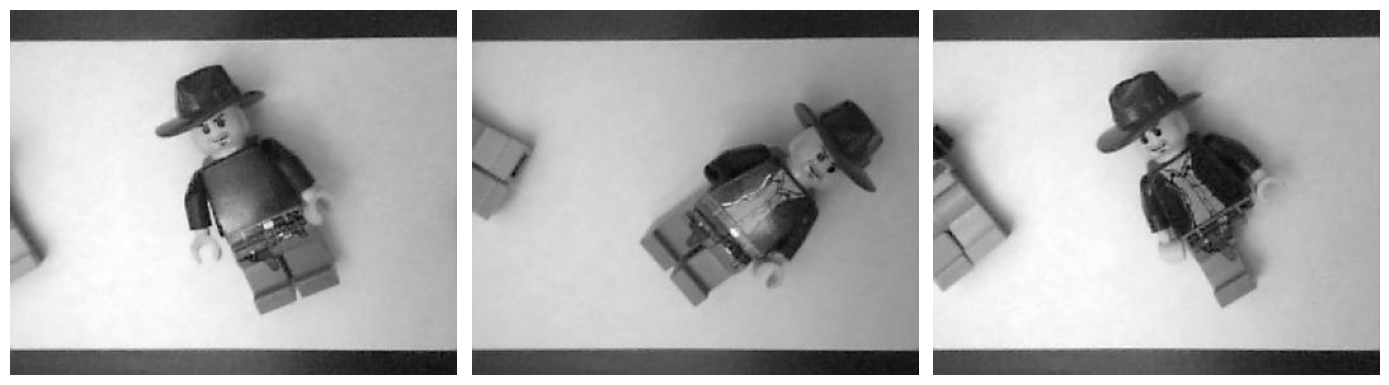


(288, 352)


In [6]:
# Uma olhada nas imagens carregadas.

# Escolher tamanho da amostra e quantidade razoáveis de colunas.
n_sample = 3

# Pega amostra.
# Dataframe.sample() retorna uma série do Pandas, não lista.
# Por isso usamos .tolist()
sample = df_init["img"].sample(n=n_sample).tolist()

# Exibe amostra.
implotmany(sample)
print(sample[0].shape)

D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     3 imgs


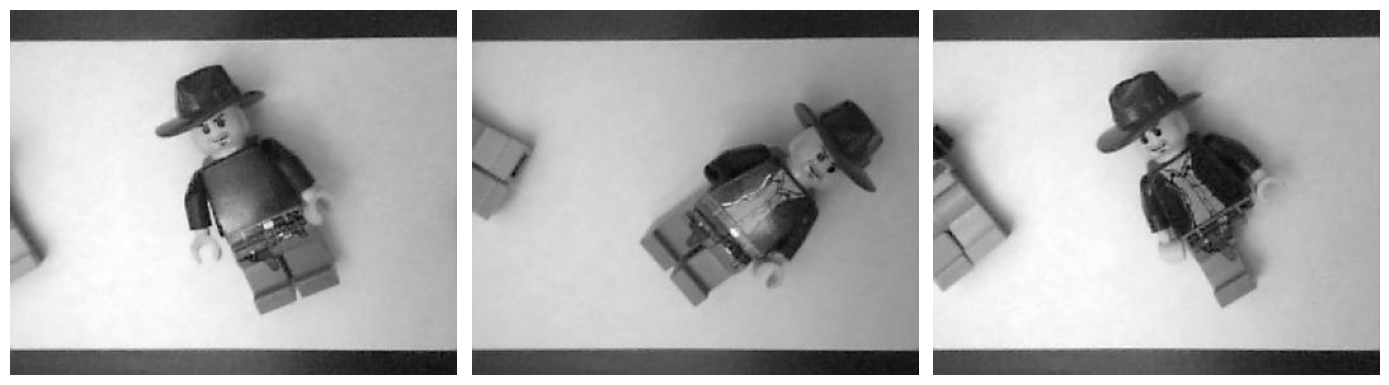


D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     3 imgs


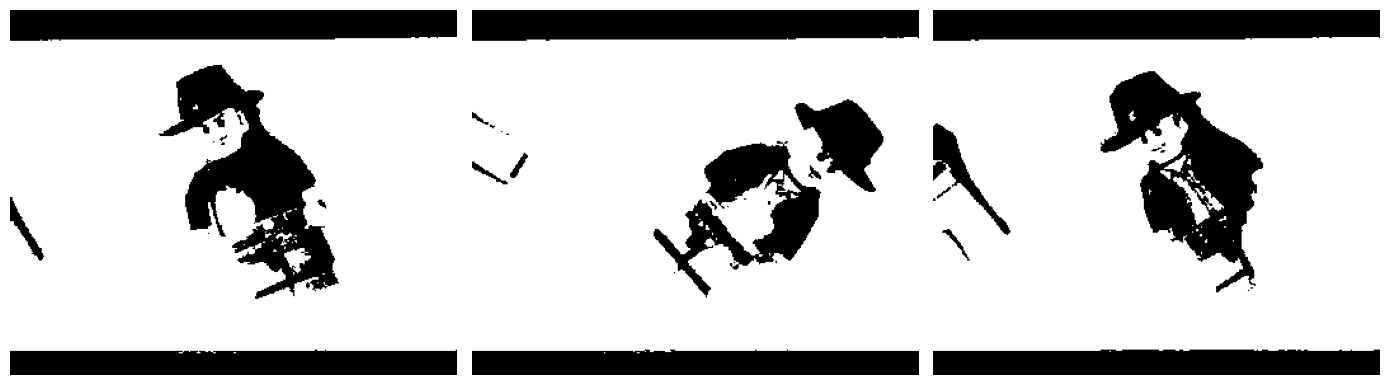


D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     3 imgs


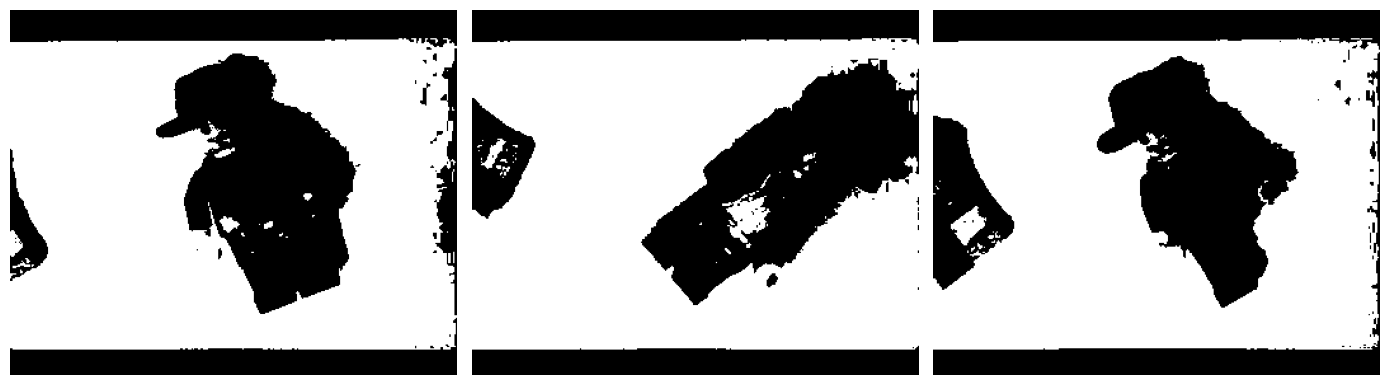

In [7]:
# Uma etapa no pipeline pode operar em cima o resultado da imagem recebida pela etapa anterior do pipeline apenas,
# ou consultar a imagem original para efetuar alguma coisa com base nela.
# A segunite função serve pra demonstrar como fazer uma etapa que usa a lista de imagens da etapa anterior
# e também consulta as imagens originais:
#
# def test_shit(data, src=None):
#     print(src)
#     return [img*0.5 for img in data]
#
# P = Pipeline(src=sample)
# P.add_process(test_shit, use_src=True)
#
# Quando use_src é omitido, o pipeline não entrega self.src para o processo.


# Pipeline 1
P1 = Pipeline(src=sample)
P1.add_preproc(binarize, threshold=96)

# Pipeline 2
P2 = Pipeline(src=sample)
P2.add_preproc(contrast_boost)
P2.add_preproc(binarize, threshold=96)


# Executa
P1.run()
P2.run()


# Mostra resultados
implotmany(sample)
P1.plot_data()
P2.plot_data()

D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     3 imgs


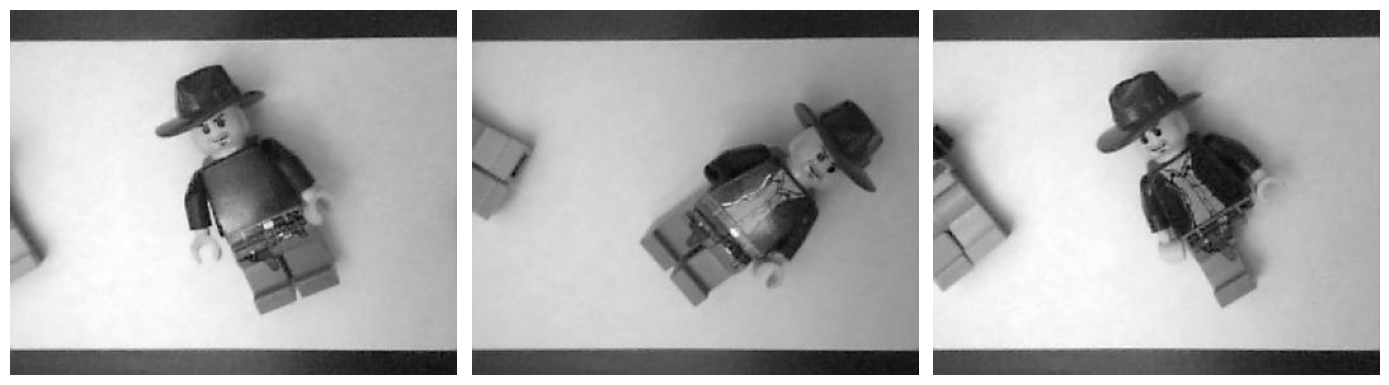


D.Type: <class 'numpy.uint8'>     Img.Shape: (288, 352)     3 imgs


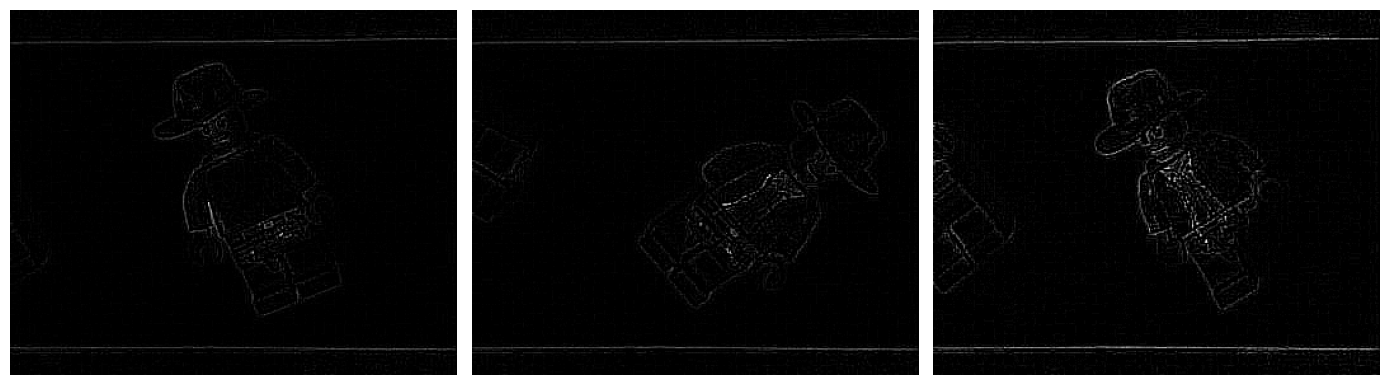

TypeError: binarize() got an unexpected keyword argument 'divide'

In [8]:
# Cópia da amostra.
imset = [img.copy() for img in sample]
implotmany(imset)


# Inverte valores.
# imset_inv = inverse(imset)
# implotmany(imset_inv)


# Filtra Passa-Alta (High Boost Pass)
kernel = np.array( [[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]]) / 9
imset_hbp = filter2D(imset, kernel)
implotmany(imset_hbp)


# Binariza.
imset_bin = binarize(imset_hbp, divide=2)
implotmany(imset_bin)


# Dilata em 1px
imset_dil = dilate(imset_bin)
implotmany(imset_dil)

# Erode em 1px
imset_ero = erode(imset_dil)
implotmany(imset_ero)


# Localiza linha mais longa de cada imagem.
imset_lines = search_longest_lines(imset_bin)

# Vizualização das linhas encontradas, desenhando elas em cópias das imagens originais.
imset_draw = drawlines(imset, imset_lines)
implotmany(imset_draw)


# Detecção de bordas.
# edges = edgesdetect_sobel(imset_bin, "tb")
# implotmany(edges)

```python
# A linha mais longa que pode haver é a diagonal principal.
threshold = int(math.sqrt(edges[0].shape[1]*edges[0].shape[1] + edges[0].shape[0]*edges[0].shape[0]))

# Solução inicial. É esperado que comece vazia.
lines_set = find_lines(edges, threshold=threshold)

# Faz uma busca decremental direta pra achar a melhor combinação de soluções.
# embora seja mais interessante fazer essa busca por imagem, e faremos assim depois.
go_next = True
for t in range(1, threshold, 10):
    
    new_set = find_lines(edges, threshold=t)
    
    for lines in new_set:
        
        try:
            line_count = len(lines)
        
        except TypeError:
            go_next = False
            break
            
        if line_count < 2: # Queremos duas linhas, a de cima e a de baixo.
            go_next = False
            break
            
    if go_next: lines_set = new_set
    else: break

lines_set
```

Para definir todos os pixels de uma imagem binária que estão acima de uma reta encontrada com `cv.HoughLines()`, você pode seguir os seguintes passos:

1. **Detectar a reta**: Use `cv.HoughLines()` para detectar a linha na imagem.
2. **Desenhar a reta**: Você pode desenhar a linha para visualizar, mas isso não é estritamente necessário para a modificação dos pixels.
3. **Modificar os pixels**: Crie uma máscara para modificar os pixels que estão acima da linha.

Aqui está um exemplo de como fazer isso:

### Exemplo de Código

```python
import cv2 as cv
import numpy as np

# Carregar a imagem binária
imagem_binaria = cv.imread('caminho/para/imagem_binaria.jpg', cv.IMREAD_GRAYSCALE)

# Detectar linhas usando HoughLines
linhas = cv.HoughLines(imagem_binaria, 1, np.pi / 180, 100)

# Verifica se foram encontradas linhas
if linhas is not None:
    for linha in linhas:
        rho, theta = linha[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

        # Desenhar a linha (opcional, para visualização)
        cv.line(imagem_binaria, (x1, y1), (x2, y2), 255, 2)  # 255 para branco

        # Definir pixels acima da reta para branco
        # Obtemos a equação da reta: y = mx + b
        m = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
        b = y1 - m * x1

        # Criar uma máscara para os pixels acima da reta
        for x in range(imagem_binaria.shape[1]):
            for y in range(imagem_binaria.shape[0]):
                if y < m * x + b:  # Acima da linha
                    imagem_binaria[y, x] = 255  # Definir para branco

# Salvar ou exibir a imagem resultante
cv.imwrite('imagem_modificada.jpg', imagem_binaria)
```

### Explicação:

1. **Carregar a imagem**: Carregue sua imagem binária em escala de cinza.
2. **Detectar a linha**: Use `cv.HoughLines()` para detectar as linhas. O retorno é uma lista de parâmetros das linhas.
3. **Desenhar a linha (opcional)**: Você pode desenhar a linha na imagem para visualização.
4. **Modificar os pixels**:
   - Calcule a inclinação (`m`) e o intercepto (`b`) da linha.
   - Use um loop para percorrer cada pixel da imagem. Se o pixel estiver acima da linha (usando a equação da reta), defina seu valor como 255 (branco).

### Observações:

- O algoritmo pode ser otimizado para evitar o loop duplo, mas isso é uma abordagem simples para ilustrar o conceito.
- Se a imagem é muito grande, considere usar operações vetoriais ou máscaras para melhorar a eficiência.

In [ ]:
# Cópia da amostra.
imset = [img.copy() for img in sample]
print("Cópia da amostra: imset")
implotmany(imset)



# Binariza.
imset_bin = binarize(imset, divide=128)
print("Binariza cópia da amostra: imset_bin")
implotmany(imset_bin)



# Inverte valores.
imset_inv = inverse(imset_bin)
print("Inverte valores binarizados: imset_inv")
implotmany(imset_inv)


# Detecção de bordas com branco no topo da borda.
imset_edges_top = edgesdetect_sobel(imset_inv, "t")
print("Mask Pt.1: Bordas detectadas de imset_inv: imset_edges_top")
implotmany(imset_edges_top)

# Localiza linha mais longa nas bordas detectadas.
imset_top_lines = search_longest_lines(imset_edges_top)
imset_draw = drawlines(imset, imset_top_lines)
print("Mask Pt.2: Linhas detectadas acima: imset_draw")
implotmany(imset_draw)

# Detecção de bordas com branco abaixo da borda.
imset_edges_bot = edgesdetect_sobel(imset_inv, "b")
print("Mask Pt.3: Bordas detectadas de imset_inv: imset_edges_bot")
implotmany(imset_edges_bot)

# Localiza linha mais longa nas bordas detectadas.
imset_bot_lines = search_longest_lines(imset_edges_bot)
imset_draw = drawlines(imset, imset_bot_lines)
print("Mask Pt.4: Linhas detectadas abaixo: imset_draw")
implotmany(imset_draw)

# Prepara uma máscara, iniciada com zeros.
imset_masks = [np.zeros_like(img) for img in imset]
print("Mask Pt.5: matriz np.zeros_like(imset): imset_masks")
implotmany(imset_masks)

# Constrói máscara para subtração.
setup_mask_inplace(imset_masks, imset_top_lines, imset_bot_lines)
print("Mask Pt.6: setup_mask_inplace(imset_masks, imset_top_lines, imset_bot_lines): imset_masks")
implotmany(imset_masks)

# Aplica subtração.
imset_masked1 = subtract(imset_inv, imset_masks)
print("Mask Pt.7: aplica máscara de subtração: imset_masked1")
implotmany(imset_masked1)

In [ ]:
# Vamos fazer fechamento.

# Como estava antes:
print("\nEstado inicial: imset_masked1")
implotmany(imset_masked1)

# Kernels em testes.
kernel = np.ones((9, 9))

# Dilata
imset_dil = dilate(imset_masked1, kernel=kernel, iterations=1)
print("Dilatação de imset_masked1: imset_dil")
implotmany(imset_dil)

# Erode
imset_ero = erode(imset_dil, kernel=kernel, iterations=1)
print("\nErosão de imset_dil: imset_ero")
implotmany(imset_ero)

In [ ]:
# Detecta componentes conexas.
n_conn_comp, labels = cv.connectedComponents(imset_ero[0])

print("Número de Comp.Con. ", n_conn_comp - 1)  # O fundo não interessa, mas é tecnicamente uma componente tbm.

# Vamos separar as componentes conexas.
conn_comp = []

# Imagem colorida que usaremos para ver os comp.con. encontrados.
img_col = cv.cvtColor(imset_ero[0], cv.COLOR_GRAY2BGR)

# Laço sobre as componentes conexas, pelos índices. O índice 0 é o fundo, que não interessa.
for i in range(1, n_conn_comp):
    # Gera cores aleatórias pras componentes.
    color = np.random.randint(0, 255, size=3).tolist()
    # Aplica a cor na imagem de visualização.
    img_col[labels == i] = color
    # Prepara uma imgbin para colocar a componente.
    img_comp = np.zeros_like(imset_ero[0])
    # Coloca branco/255 onde a componente está presente.
    img_comp[labels==i] = 255
    # Adiciona componente na lista de componentes.
    conn_comp.append(img_comp)

# Plotar a imagem com pyplot
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(img_col, cv.COLOR_BGR2RGB))  # Converte de BGR para RGB para correta exibição
plt.axis('off')  # Desliga os eixos
plt.title(f'Componentes Conexos')
plt.show()

# Mosta cas componentes isoladas.
implotmany(conn_comp)

In [ ]:
# Agora desejamos isolar a maior componente.
biggest_comp = None
best_sum = 0
for comp in conn_comp:
    s = comp.sum()
    if s > best_sum:
        best_sum = s
        biggest_comp = comp

implot(biggest_comp)    

In [ ]:
# Supondo que 'largest_component' seja a sua imagem binária da maior componente
# Encontrar os contornos
contours, _ = cv.findContours(biggest_comp, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Criar uma nova imagem para o casco convexo
img_conv_hull = np.zeros_like(biggest_comp)

if contours:
    # Calcular o casco convexo para o primeiro contorno encontrado
    hull = cv.convexHull(contours[0])
    # Desenhar o casco convexo na imagem
    cv.drawContours(img_conv_hull, [hull], -1, (255), thickness=cv.FILLED)

implot(img_conv_hull)

## Pipelines

**Referência de código**

```python
def find_contours(imset: list):
    # cv2.findContours(image, mode, method[, contours[, hierarchy[, offset]]]) -> image, contours, hierarchy
    cntrset = []
    for img in imset:
        # Equivalente a      cv2.findContours(img_bin,  cv2.RETR_LIST,      cv2.CHAIN_APPROX_SIMPLE)
        contours, hierarchy = cv.findContours(img,      mode=cv.RETR_LIST,  method=cv.CHAIN_APPROX_TC89_KCOS)
        cntrset.append(contours[0])
    return cntrset


def moments(cntrset: list):
    momentset = []
    for cntr in cntrset:
        momentset.append( cv.moments(cntr[0]) )
    return momentset


def hu_moments(momentset: list):
    humset = []
    for m in momentset:
        humset.append( cv.HuMoments(m) )
    return humset


def array_to_tuple(arr):
    """Converts array to tuple"""
    return tuple(arr.reshape(1, -1)[0])


def draw_contour_points(imset, cntrset, color=(255, 255, 255)):
    """Draw all points from a list of contours"""
    imset_out = []
    
    for i in range(len(imset)):
        
        img_color = cv.cvtColor(imset[i], cv.COLOR_GRAY2BGR)
        
        contrs_sqzd = np.squeeze(cntrset[i])
        for p in contrs_sqzd:
            pp = array_to_tuple(p)
            cv.circle(img_color, pp, 3, (0, 0, 255), -1)

        imset_out.append(img_color)
    
    return imset_out


# Encontra os contornos dos cascos convexos.
#
contour_set = find_contours(P1.data)
#
# Esse código aqui é só pra visualizar os pontos encontrados para os contornos.
#
# imset_cntrnd = draw_contour_points(P1.data, contour_set)
# for img in imset_cntrnd:
#     cv.imwrite("tmp_img.png", img)
#     display(Image(filename="tmp_img.png"))

# Encontra os momentos dos contornos.
moment_set = moments(contour_set)

# Momentos Hu
hu_moment_set = hu_moments(moment_set)
```

**Propriedades extraídas dos momentos**

Área do contoro:
* Área = m00

Centróid do contorno:  
* x = m10 / m00  
* y = m01 / m00

Arredondamento: o quanto o contorno se aproxima de um círculo.  
Um círculo perfeito tem roundness 1, e quanto maior o valor, menos a
imagem se aproxima de um círculo.
```python
def roundness(contour, moments):
"""Calculates the roundness of a contour"""
    length = cv2.arcLength(contour, True)
    k = (length * length) / (moments['m00'] * 4 * np.pi)
    return k
```

Excentricidade / Alongamento: medida de o quão elíptico o contorno é.  
Pode ser calculada a partir de um elipse sobre o contorno, ou a partir de momentos.
```python
def eccentricity_from_ellipse(contour):
    """Calculates the eccentricity fitting an ellipse from a contour"""
    (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
    a = ma / 2
    b = MA / 2
    ecc = np.sqrt(a ** 2 - b ** 2) / a
    return ecc

def eccentricity_from_moments(moments):
    """Calculates the eccentricity from the moments of the contour"""
    a1 = (moments['mu20'] + moments['mu02']) / 2
    a2 = np.sqrt(4 * moments['mu11'] ** 2 + (moments['mu20'] - moments['mu02']) **2) / 2
    ecc = np.sqrt(1 - (a1 - a2) / (a1 + a2))
    return ecc
```

Aspect Ratio:
```python
def aspect_ratio(contour):
    """Returns the aspect ratio of the contour based on the dimensions of the bounding rect"""
    x, y, w, h = cv2.boundingRect(contour)
    res = float(w) / h
    return res
```

Utilitário
```python
def get_position_to_draw(text, point, font_face, font_scale, thickness):
    """Gives the coordinates to draw centered"""
    text_size = cv2.getTextSize(text, font_face, font_scale, thickness)[0]
    text_x = point[0] - text_size[0] / 2
    text_y = point[1] + text_size[1] / 2
    return round(text_x), round(text_y)
```

In [ ]:
# Uma etapa no pipeline pode operar em cima o resultado da imagem recebida pela etapa anterior do pipeline apenas,
# ou consultar a imagem original para efetuar alguma coisa com base nela.
# A segunite função serve pra demonstrar como fazer uma etapa que usa a lista de imagens da etapa anterior
# e também consulta as imagens originais:
#
# def test_shit(data, src=None):
#     print(src)
#     return [img*0.5 for img in data]
#
# P = Pipeline(src=sample)
# P.add_process(test_shit, use_src=True)
#
# Quando use_src é omitido, o pipeline não entrega self.src para o processo.



P1 = Pipeline( src=df_init["img"].tolist() )

P1.add_preproc(binarize, threshold_method="otsu")  # threshold_method : otsu niblack sauvola triangle
P1.add_preproc(inverse)
P1.add_preproc(remove_table_borders)
P1.add_preproc(morph_closing, kernel_size=9)
P1.add_preproc(isolate_highest_area_conn_comp)  # Em geral, aqui está o problema de selecionar o lego errado na mesa.
P1.add_preproc(rectangle_hull)
P1.add_preproc(extract_by_mask, use_src=True)


P1.run()


# print("\nP1.src")
# implotmany(P1.src)

# print("P1.plot_data()")
# P1.plot_data()

implotmany(P1.data, n_cols=5)

In [ ]:
P2 = Pipeline(src=[img.copy() for img in P1.data])

In [ ]:
implotmany(P2.src, n_cols=5)

In [ ]:
P2.add_preproc(binarize, threshold_method="otsu")

P2.run()

implotmany(P2.data, n_cols=5)